# **Bank Term Deposit**

dataset : https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

## **Introduction and Project Goals**

**Problem Statment :**

The bank's telemarketing campaigns have low conversion rates and are resource intensive. The bank wants to reduce cost overruns by targeting customers who are highly likely to purchase term deposits, but currently lacks an effective predictive tool to proactively identify such customers.

**Project Goals :**
*   Determine clusters among the sample population that will most likely open term deposit accounts.

**What is a Term Deposit?**

A Term deposit is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time.

---

**RISP-DM Sample Framework**
1. **Business Understanding**

Understand the bank's business needs: increase the effectiveness of marketing campaigns for term deposits, and reduce contact costs to uninterested customers.

2. **Data Understanding**

Conduct initial exploration of customer data and contact history, identify variable distributions, missing values, and early patterns that emerge (e.g., the influence of a particular job or month on success).

3. **Data Preparation**

Clean the data, handle 'unknown' values, convert categorical variables into numeric formats (one-hot encoding/label encoding)

4. **Exploratory Data Analyst**

Focus on discovery and insight into data

5. **Modeling**

Build several prediction models (e.g.: Logistic Regression, Decision Tree, Random Forest, XGBoost) and evaluate their performance based on metrics such as Accuracy, Precision, Recall, and AUC.

6. **Evaluation**

Assess whether the model has met the business objectives: prediction accuracy and feature interpretation. Compare models and choose the best one according to the business context.

Attributes Description:

Input variables:

**bank client data:**
1. age: (numeric)
2. job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education: (categorical: primary, secondary, tertiary and unknown)
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. balance: Balance of the individual.


**Related with the last contact of the current campaign:**
9. contact: contact communication type (categorical: 'cellular','telephone')
10. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11. day: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**Output variable (desired target):**
17. deposit - has the client subscribed a term deposit? (binary: 'yes','no')

## **Data Understanding**

### **Import Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install lazypredict
!pip install plotly
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project Data Science/Bank/bank.csv')
df

The dataset has 11162 rows and 17 columns.

### **Checking Missing Value, Duplicated and Descriptive Statistic**

In [ ]:
df.info()

In [ ]:
#checking missing value
print("Duplicated Data : ", df.duplicated().sum())
print(df.isna().sum())
df.describe()

In [ ]:
df.describe(include='object')

In [ ]:
#checking distribution numerical data
df.hist(bins=50, figsize=(20,15))
plt.show()

## **Data Preparation**

### **Data Cleaning**

In [ ]:
# Handle Unknown into all column for encoding
df = df.replace('unknown', np.nan)
df.info()

In [ ]:
# drop poutcome and missing value handling
df = df.drop('poutcome', axis=1)
df = df.dropna()
df.info()

In [ ]:
# Checking unique Value dan value count
feature = df.columns.to_list()
for i in feature:
   print(f'the number of unique values of {i} is {len(df[i].unique())}')
   values_counts = pd.DataFrame(df[i].value_counts())
   print(f'the values of the {i} are : \n{values_counts}')
   print('=========================================')

### **Feature Engineering**

**Encode Categorical**

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(label_encoder.fit_transform)
df.T

**Correlation Column**

In [ ]:
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**VIF**

In [ ]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

calculate_vif(df)

**Split Data**

In [ ]:
X = df.drop('deposit', axis=1)
y = df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

## **Exploratory Data Analyst**

### **Distribution Target Variable**

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='deposit', data=df, palette='vlag')
total = len(df)

# Tambahkan label jumlah dan persentase di atas batang
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n({percentage:.1f}%)', (x, y), ha='center', va='bottom')

plt.xlabel('Deposit')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

* **53.8%** of the Clients are not subsribed for the Term Deposits.
* only **46.2%** are subsribed to the term deposits

### **Analyst Categorical Variable**

**Job by Customer**

In [ ]:
job_map = {
    0: 'admin.',
    1: 'blue-collar',
    2: 'entrepreneur',
    3: 'housemaid',
    4: 'management',
    5: 'retired',
    6: 'self-employed',
    7: 'services',
    8: 'student',
    9: 'technician',
    10: 'unemployed'
}

X_train['job'] = X_train['job'].map(job_map)

# Hitung dan urutkan berdasarkan Count
job_counts = X_train['job'].value_counts().reset_index()
job_counts.columns = ['Job', 'Count']

# Ambil urutan job dari data yang sudah di-sort
job_order = job_counts['Job']

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=job_counts, x='Job', y='Count', palette='vlag', order=job_order)

# Tambah label count di atas batang
for i in ax.patches:
    ax.annotate(f"{int(i.get_height())}",
                (i.get_x() + i.get_width() / 2, i.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title("Job Type of the Customers")
plt.xlabel("Job")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Top Total Job Type by the Customers**

4) management      1714

9) technician      1139

1) blue-collar     940

0) admin.          833

5) retired          519

7) services         516

6) self-employed    246

10) unemployed       231

8) student          223

2)entrepreneur     186

3) housemaid        167


---



**Marital Status by Customers**

In [ ]:
marital_map = {
    0: 'divorced',
    1: 'married',
    2: 'single'
}

X_train['marital'] = X_train['marital'].map(marital_map)

# Hitung jumlah tiap kategori
marital_counts = X_train['marital'].value_counts()
labels = marital_counts.index
counts = marital_counts.values

# Buat fungsi format label persentase + count
def make_autopct(counts):
    def my_autopct(pct):
        total = sum(counts)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_autopct

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=None, autopct=make_autopct(counts),
        colors=plt.cm.Set2.colors, startangle=90, textprops={'fontsize': 12})
plt.title('Marital Status of the Customers')

# Tambahkan legenda di luar chart
plt.legend(labels=labels, title="Marital Status", loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.show()

**Top Marital Status of the Customers**

1) married    (3765)

2) single     (2180)

0) divorced   (769)


---



**Education by Customers**

In [ ]:
education_map = {
    0: 'primary',
    1: 'secondary',
    2: 'tertiary'
}

X_train['education'] = X_train['education'].map(education_map)

# Hitung jumlah masing-masing kategori education
education_order = X_train['education'].value_counts().index

# Plot
plt.figure(figsize=(10,6))
ax = sns.countplot(data=X_train, x='education', palette='vlag', order=education_order)
total = len(X_train)

# Tambahkan count dan persentase di dalam batang
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.annotate(f'{count}\n({percentage:.1f}%)', (x, y), ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Education of the Customers')
plt.tight_layout()
plt.show()


**Top Education of the Customers**

1) secondary   3337

2) tertiary    2551

0) primary 826


---



**Credit and Loan Analyst**

In [ ]:
import matplotlib.pyplot as plt

# Siapkan data
default_counts = X_train['default'].value_counts()
housing_counts = X_train['housing'].value_counts()
loan_counts = X_train['loan'].value_counts()

# Warna sama dengan Plotly
colors = ['crimson', 'forestgreen']

# Fungsi untuk format label
def make_autopct(values):
    def autopct(pct):
        count = int(round(pct / 100. * sum(values)))
        return f'{pct:.1f}%\n({count})'
    return autopct

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Credit and Loan Analysis', fontsize=16, fontweight='bold', fontfamily='serif')

# Donut 1: Credit in Default
axes[0].pie(default_counts, labels=default_counts.index, colors=colors,
            autopct=make_autopct(default_counts), startangle=90, wedgeprops=dict(width=0.4, edgecolor='black'))
axes[0].set_title('Credit in Default', fontsize=14, fontfamily='serif')

# Donut 2: Housing Loan
axes[1].pie(housing_counts, labels=housing_counts.index, colors=colors,
            autopct=make_autopct(housing_counts), startangle=90, wedgeprops=dict(width=0.4, edgecolor='black'))
axes[1].set_title('Housing Loan', fontsize=14, fontfamily='serif')

# Donut 3: Personal Loan
axes[2].pie(loan_counts, labels=loan_counts.index, colors=colors,
            autopct=make_autopct(loan_counts), startangle=90, wedgeprops=dict(width=0.4, edgecolor='black'))
axes[2].set_title('Personal Loan', fontsize=14, fontfamily='serif')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # beri ruang untuk judul atas
plt.show()

**Top Credit in Default**
* (0) No        6640 (98.9%)
* (1) yes        74 (1.1%)

**Top Housing Loan**
* (0) No        3915 (58.3%)
* (1) yes        2799 (41.7%)

**Top Personal Loan**
* (0) No        5822 (86.7%)
* (1) yes        892 (13.3%)



INSIGHT
* **98.9 %** customers in the bank doesn't have Credit in Default
* **58.3 %** customers in the bank doesn't have Housing Loan
* **86.7 %** customers in the bank doesn't have Personal Loan
* on comparing with **Personal Loan** and **Housing Loan**, Most of the **clients subscribed** for **Housing Loan** - **41.7%**


---




**Contact of the Customers**

In [ ]:
contact_map = {
    0: 'cellular',
    1: 'telephone'
}

X_train['contact'] = X_train['contact'].map(contact_map)

# Ambil data dari kolom 'contact' di X_train
contact_count = X_train['contact'].value_counts()
label_contact = contact_count.index
count_contact = contact_count.values

colors = ['crimson', 'forestgreen']

# Fungsi untuk menampilkan persentase + count
def make_autopct(counts):
    def my_autopct(pct):
        total = sum(counts)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_autopct

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(count_contact, labels=None, autopct=make_autopct(count_contact),
        colors=colors, startangle=90, textprops={'fontsize': 12})
plt.title('Contact Type of the Customers')

# Tambahkan legenda
plt.legend(labels=label_contact, title="Contact Type", loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()


**Top Contact of the Costumers**

* cellular    6138 (91.4%)
* telephone    576 (8.6%)

**INSIGHT**
* Most of the customers in the bank are contacted through Cellular **91.4%**
* only **8.6%** of the clients are contacted through telephone


---



**Last Contact Month of the year**

In [ ]:
# Hitung jumlah tiap bulan

month_map = {
    0: 'apr',
    1: 'aug',
    2: 'dec',
    3: 'feb',
    4: 'jan',
    5: 'jul',
    6: 'jun',
    7: 'mar',
    8: 'may',
    9: 'nov',
    10: 'oct',
    11: 'sep',
}

X_train['month'] = X_train['month'].map(month_map)

month_counts = X_train['month'].value_counts().reset_index()
month_counts.columns = ['month', 'Count']
month_counts = month_counts.sort_values(by='Count', ascending=False)

# Atur urutan kategori sesuai urutan Count
month_counts['month'] = pd.Categorical(month_counts['month'], categories=month_counts['month'], ordered=True)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=month_counts, x='month', y='Count', palette='vlag', edgecolor='black')

# Tambahkan label nilai di atas bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

# Tambahkan info visual
plt.title('Last Contact Month of the Year', fontsize=14, fontweight='bold', fontfamily='serif')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


* Most of the clients in the bank are contacted in the months of May, Jul,nov,apr,feb and in Aug last year.
* very few of the clients are contacted in the months of Sep, Mar and in Dec

### **Term Deposits based on Marital Status**

In [ ]:
import matplotlib.pyplot as plt

mapping = {
    0: 'divorced',
    1: 'married',
    2: 'single'
}
df['marital'] = df['marital'].map(mapping)

# Grup data
d = df.groupby(['marital', 'deposit'], as_index=False)['age'].count().rename(columns={'age': 'Count'})

# Ambil nilai unik marital (agar tidak hardcode)
statuses = d['marital'].unique()
colors = ['crimson', 'forestgreen']  # Updated color list


# Buat plot
fig, axs = plt.subplots(1, len(statuses), figsize=(18, 6))
fig.suptitle('Term Deposits based on Marital Status', fontsize=16, fontweight='bold')

for i, status in enumerate(statuses):
    data = d[d['marital'] == status]
    axs[i].pie(data['Count'],
               labels=data['deposit'],
               autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(data['Count'])))})",
               colors=colors,
               startangle=90,
               wedgeprops={'edgecolor': 'black'})
    axs[i].set_title(status.capitalize())

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


* Out of **divorced** Clients, **45.5%** are subscribed and **54.5%** are not subscribed to the term deposits
* Out of **married** Clients, **50.0%** are subscribed and **50.0%** are not subscribed to the term deposits
* Out of **single** Clients, **40.0%** are subscribed and **60%** are not subscribed to the term deposits

### **Term Deposits based on Job Type**

In [ ]:
import plotly.io as pio

pio.renderers.default = 'colab'

job_mapping = {
    0: 'admin.',
    1: 'blue-collar',
    2: 'entrepreneur',
    3: 'housemaid',
    4: 'management',
    5: 'retired',
    6: 'self-employed',
    7: 'services',
    8: 'student',
    9: 'technician',
    10: 'unemployed'
}

deposit_mapping = {
    0: 'no',
    1: 'yes'
}

# Terapkan mapping ke kolom 'job'
df['job'] = df['job'].map(job_mapping)
df['deposit'] = df['deposit'].map(deposit_mapping)

fig=px.treemap(df.groupby(['job','deposit'],as_index=False)['age'].count().rename(columns={'age':'Count'}),path=['job','deposit','Count'],template='simple_white')
fig.update_layout(title_x=0.5,template='simple_white',title_text='<b style="color:black; font-size:100%;">Treemap on count of clients who subscribed the Term Deposits or not based on Job',font_family="Times New Roman",title_font_family="Times New Roman")
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.show()

### **Effect of Age on Term Deposits**

In [ ]:
# Group dan rename
grouped_df = df.groupby(['age', 'deposit'], as_index=False)['job'].count().rename(columns={'job': 'Count'})

# Pivot agar setiap kategori 'deposit' menjadi kolom (yes/no)
pivot_df = grouped_df.pivot(index='age', columns='deposit', values='Count').fillna(0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['yes'], label='yes', color='ForestGreen')
plt.plot(pivot_df.index, pivot_df['no'], label='no', color='DarkBlue')

# Formatting
plt.title('Effect of Age on Term Deposits', fontsize=16, fontname='serif', weight='bold', loc='left')
plt.xlabel('Age', fontsize=12, fontname='serif')
plt.ylabel('Count', fontsize=12, fontname='serif')
plt.legend(title='Term Deposit', title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontname='serif')
plt.yticks(fontname='serif')
plt.tight_layout()
plt.show()

**Insight**

1. The peak number of customers is at the age of 30-35 years, for both yes and no.

2. Younger customers (< 30) tend to be more non-subscribers.

3. After the age of 30-35, the number of clients decreases for all categories.

4. At older ages (60+), the number of clients decreases drastically, but the percentage of "yes" is relatively greater than "no", although the total is small.

### **Effect of Duration on Term Deposits**

In [ ]:
# 1. Buat kolom kategori durasi
df['Duration'] = df['duration'].apply(lambda x: 'Above_Average_Duration' if x >= df['duration'].mean() else 'Below_Average_Duration')

# 2. Group dan hitung
a = df.groupby(['Duration', 'deposit'], as_index=False)['age'].count().rename(columns={'age': 'Count'})

# 3. Hitung persentase
a['percent'] = round(a['Count'] * 100 / a.groupby('Duration')['Count'].transform('sum'), 1)
a['percent_label'] = a['percent'].apply(lambda x: f'{x}%')

# 4. Pivot untuk visualisasi
pivot_df = a.pivot(index='Duration', columns='deposit', values='Count').fillna(0)
percent_labels = a.pivot(index='Duration', columns='deposit', values='percent_label')

# 5. Plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(pivot_df))

# Bar
bar1 = ax.bar(index - bar_width/2, pivot_df['no'], bar_width, label='no', color='MediumPurple', edgecolor='black')
bar2 = ax.bar(index + bar_width/2, pivot_df['yes'], bar_width, label='yes', color='YellowGreen', edgecolor='black')

# Tambahkan persentase di atas bar
for i in range(len(index)):
    ax.text(index[i] - bar_width/2, pivot_df['no'].iloc[i] + 2, percent_labels['no'].iloc[i], ha='center', fontsize=10, fontname='serif')
    ax.text(index[i] + bar_width/2, pivot_df['yes'].iloc[i] + 2, percent_labels['yes'].iloc[i], ha='center', fontsize=10, fontname='serif')

# Pengaturan tampilan
ax.set_xticks(index)
ax.set_xticklabels(pivot_df.index, fontname='serif')
ax.set_ylabel('Count', fontname='serif')
ax.set_title('Effect of Duration on Term Deposits\nBy taking the above average duration and below average duration', fontsize=14, fontname='serif', loc='left', weight='bold')
ax.legend(title='Deposit Status', title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


* if the duration is **above average** then **81.0 %** of clients are **subscribed** to term deposits and **19.0 %** are **not subscribed**
* if the duration is **below average** then **39.1%** of clients are **subscribed** to term deposits and  **60.9 %** are **not subscribed**

### **Deposits based on last Contact month**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

month_mapping = {
    0: 'apr',
    1: 'aug',
    2: 'dec',
    3: 'feb',
    4: 'jan',
    5: 'jul',
    6: 'jun',
    7: 'mar',
    8: 'may',
    9: 'nov',
    10: 'oct',
    11: 'sep',
}
df['month'] = df['month'].map(month_mapping)

a=df.groupby(['month','deposit'],as_index=False)['age'].count().rename(columns={'age':'Count'})
# Assuming 'a' is already prepared as in your original code
a['percent'] = round(a['Count'] * 100 / a.groupby('month')['Count'].transform('sum'), 1)
a['percent'] = a['percent'].apply(lambda x: f'{x}%')

# Define colors
colors = ['MediumPurple', 'YellowGreen']

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through the data and plot the bars for each 'deposit' category
for idx, deposit in enumerate(a['deposit'].unique()):
    deposit_data = a[a['deposit'] == deposit]
    bar_width = 0.35
    positions = np.arange(len(deposit_data)) + bar_width * idx
    ax.bar(positions, deposit_data['Count'], width=bar_width, label=deposit, color=colors[idx])

    # Add text labels (percent) on top of each bar
    for i, count in enumerate(deposit_data['Count']):
        ax.text(positions[i], count + 2, deposit_data['percent'].iloc[i], ha='center', va='bottom', fontsize=9)

# Set titles and labels
ax.set_title('Deposits based on last Contact month', fontsize=16, fontweight='bold', family="serif")
ax.set_xlabel('Month', fontsize=12, family="serif")
ax.set_ylabel('Count', fontsize=12, family="serif")
ax.set_xticks(np.arange(len(a['month'].unique())))
ax.set_xticklabels(a['month'].unique(), rotation=45, ha='right', fontsize=10, family="serif")

# Customize the legend
ax.legend(title="Deposit", fontsize=12)

# Add gridlines and format
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

**Insight**
* Most of the clients in the bank are contacted in the months of May, Jun, Jul and in Aug last year. More Clients subscribed to term deposits in this months only.
* very few of the clients are contacted in the months of Sep, Mar and in Dec. Even less contacts performed in these months, more number of clients subscribed to term deposits in these months. It is better to Contact clients more in this months.

## **Modelling**

### **Scalling**

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(label_encoder.fit_transform)
df.T

In [ ]:
X = df.drop('deposit', axis=1)
y = df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

In [ ]:
from re import S
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **Lazy Classifier**

In [ ]:
clf = LazyClassifier(predictions = True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

### **Random Forest Classifier**

In [ ]:
re = RandomForestClassifier()
re.fit(X_train, y_train)
y_pred = re.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
#cek train test random forest
train_acc = re.score(X_train, y_train)
test_acc = re.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)

**Model Overfitting**

---



**Hyperparameter Tuning**



---



In [ ]:
modelre1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
    )
modelre1.fit(X_train, y_train)
y_pred = modelre1.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
train_acc = modelre1.score(X_train, y_train)
test_acc = modelre1.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)

### **LGBMClassifier**

In [ ]:
lgm = LGBMClassifier()
lgm.fit(X_train, y_train)
y_pred = lgm.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
train_acc = lgm.score(X_train, y_train)
test_acc = lgm.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#

**Hyperparameter Tuning**

In [ ]:
modellgbm = LGBMClassifier(
    n_estimators=100,          # jumlah pohon
    max_depth=10,              # batasi kedalaman pohon
    min_samples_split=5,       # min sample untuk split
    min_samples_leaf=4,        # min sample di daun
    max_features='sqrt',       # fitur yang dipilih setiap split
    random_state=42
)
modellgbm.fit(X_train, y_train)
y_pred = modellgbm.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = modellgbm.score(X_train, y_train)
test_acc = modellgbm.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#

### **Logistic Regression**

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#



---



In [ ]:
# hyperparameter tuning
modellr = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='liblinear',
    max_iter=50,
    random_state=42
)
modellr.fit(X_train, y_train)
y_pred = modellr.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = modellr.score(X_train, y_train)
test_acc = modellr.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#

### **XGBClassifier**

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = xgbc.score(X_train, y_train)
test_acc = xgbc.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#



---



In [ ]:
modelxgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    min_child_weight=3,
    random_state=42,
    verbosity=1
)
modelxgb.fit(X_train, y_train)
y_pred = modelxgb.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = modelxgb.score(X_train, y_train)
test_acc = modelxgb.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#

### **Decision Tree**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = dt.score(X_train, y_train)
test_acc = dt.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#



---



In [ ]:
modeldt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
modeldt.fit(X_train, y_train)
y_pred = modeldt.predict(X_test)
print(classification_report(y_test, y_pred))
#

In [ ]:
train_acc = modeldt.score(X_train, y_train)
test_acc = modeldt.score(X_test, y_test)
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
#

## **Evaluate**

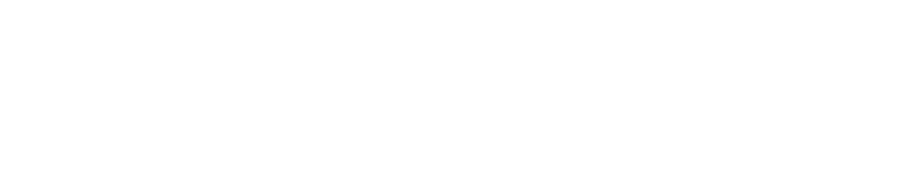

**Hyperparameter Tuning**

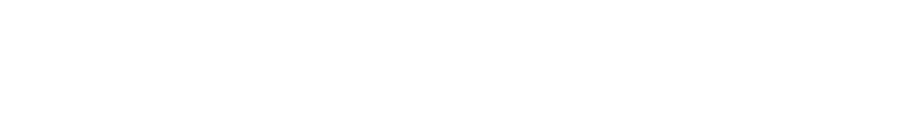

In [ ]:
#buat feature important
feature_importances = modellgbm.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sorted_idx]
feature_names = feature_names[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances, align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
#buat nilai featur importancenya
feature_importances = modellgbm.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sorted_idx]
feature_names = feature_names[sorted_idx]

for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance}")

In [ ]:
import shap
import matplotlib.pyplot as plt

# Inisialisasi explainer untuk model tree-based (LGBM, XGBoost, RandomForest)
explainer = shap.TreeExplainer(modellgbm)

# Hitung SHAP values
shap_values = explainer.shap_values(X_test)


In [ ]:
# Summary plot: Fitur paling penting secara global
shap.summary_plot(shap_values, X_test)


In [ ]:
# Bar plot: hanya ranking fitur
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
# Ganti ini dengan nama kolom asli kamu
feature_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
                 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
                 'previous', 'poutcome']

# Ubah X_test ke DataFrame
X_test = pd.DataFrame(X_test, columns=feature_names)

In [ ]:
explainer = shap.TreeExplainer(modellgbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# menampilkan nilai shape di dalam bar plot

In [ ]:
shap_df.head()

In [ ]:
expected_value = explainer.expected_value  # bisa scalar atau list (untuk multiclass)
# SHAP value semua fitur
row = shap_values[5]  # SHAP values untuk baris ke-0
log_odds = expected_value + row.sum()
prob = 1 / (1 + np.exp(-log_odds))
print("Predicted probability:", prob)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

## **Conclution**

* Telemarketing call duration

➤ The longer the duration, the more likely the customer is interested.

➡ Focus on quality conversations.

* Campaign time (month & day)

➤ There are certain times that are more effective.

➡ Schedule campaigns at the best time.

* Customer characteristics (age & savings balance)

➤ Older customers with large balances are more responsive.

➡ Target this segment.

* 💡 Other Supporting Factors:

 * Previous contact history (pdays)

 * Type of employment and home ownership status

* ⚠️ Less Important Factors:
 * Default (failure to pay)

 * Type of contact (mobile/home)

 * Personal loans

Recommendations:
* Train agents to have longer, more effective conversations

* Schedule campaigns during the best months/days

* Focus on customers with high balances and a certain age

* Personalize your approach based on customer data